# Setup

In [1]:
!pip install --upgrade albumentations

In [2]:
!pip install torchcam

In [3]:
!pip install ipywidgets

# Import & Utils

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataSet import QuestionDataSet
import PullupModel as pm

import random

from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn import metrics as skmetrics

In [2]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])

In [3]:
import cv2
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


def display_digits_with_keypoints(images, key_points, true_keypoints, iou, title):

    n = len(images)
    iou_threshold = 0.5
    fig = plt.figure(figsize=(45, 15))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n): 
        ax = fig.add_subplot(2, 10,i+1)
        bboxe = key_points[i]
        true_bboxe = true_keypoints[i]
        image = images[i]
        image_width = 1# image.shape[1]
        image_height = 1#image.shape[0]
        
        img_to_draw = cv2.circle(image,  (int(key_points[0] * image_width) , int(key_points[1] * image_height)), 5, (100,0,255), -1)
        img_to_draw = cv2.circle(img_to_draw,  (int(key_points[2] * image_width), int(key_points[3] * image_height)), 5, (0,0,255), -1)
        img_to_draw = cv2.circle(img_to_draw,  (int(true_keypoints[0] * image_width) , int(true_keypoints[1] * image_height)), 5, (100,255,0), -1)
        img_to_draw = cv2.circle(img_to_draw,  (int(true_keypoints[2] * image_width), int(true_keypoints[3] * image_height)), 5, (0,255,0), -1)
        plt.xticks([])
        plt.yticks([])
    
        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (iou[i] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(iou[i]), color=color, transform=ax.transAxes)
        

In [4]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device("cuda")
else:    
    device = torch.device("cpu")
print(device)
model = pm.create_model()
model = model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
#print(model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1,

In [5]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce GTX 970M
Memory Usage:
Allocated: 0.1 GB
Cached:    1.4 GB


In [6]:
# hyperparameters related to the dataloader
train_loader_shuffle = True
val_loader_shuffle = True
batch_size_train = 16
batch_size_val = 32
n_workers = 0


# init normalising mean and std
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]


simple_transform = A.Compose([A.Resize(224, 224),
                            A.Normalize(),
                            ToTensorV2()],
                          )
vanilla_transform = torchvision.transforms.Compose([
                                                    torchvision.transforms.Resize(224),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(norm_mean, norm_std)])

base_transform =  A.Compose([A.Resize(224, 224),
                            A.Normalize(),
                            ToTensorV2()],
                           keypoint_params=A.KeypointParams(format='xy',
                                                           remove_invisible=False)
                          )
#  A.ShiftScaleRotate(p=0.5, rotate_limit=15)
init_transform = A.Compose([A.Affine(scale={"x":(0.8,1.2),"y":(1,1)}),
                            A.Affine(scale=(0.9,1.3), translate_percent={"x":(-0.3,0.3),"y":(-0.15,0.3)}),
                            A.Resize(224, 224),
                            A.HorizontalFlip(p=0.4),
                            A.SafeRotate(limit=(-3,3), p=0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.MedianBlur (blur_limit=3, always_apply=False, p=0.1),
                            A.RGBShift(r_shift_limit=(-15,15), g_shift_limit=(-15,15), b_shift_limit=(-15,15), always_apply=False, p=0.1), 
                            A.Normalize(),
                            ToTensorV2()],
                           keypoint_params=A.KeypointParams(format='xy',
                                                           remove_invisible=False)
                          )
data_folder = 'data/'

# instanciate our training and validation datasets
train_dataset = QuestionDataSet(root=data_folder, setting="training",
                                    transform=base_transform)
val_dataset = QuestionDataSet(root=data_folder, setting="validation",
                                   transform=base_transform)
# test dataset aggregates new images grom google image and images from filmed pullup workout not used in the other sets 
test_dataset = QuestionDataSet(root=data_folder, setting="testing",
                                   transform=base_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=train_loader_shuffle,
                                               pin_memory=True, num_workers=n_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=val_loader_shuffle,
                                              pin_memory=True, num_workers=n_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_val, shuffle=val_loader_shuffle,
                                              pin_memory=True, num_workers=n_workers)


train_dataset_hanging_only = QuestionDataSet(root=data_folder, setting="training",
                                             transform=init_transform, training_proportion=1, only_hanging=True)
val_dataset_hanging_only = QuestionDataSet(root=data_folder, setting="validation",
                                           transform=init_transform, only_hanging=True)
train_loader_hanging_only = torch.utils.data.DataLoader(train_dataset_hanging_only, batch_size=batch_size_train, 
                                                        shuffle=train_loader_shuffle,
                                                        pin_memory=True, num_workers=n_workers)
val_loader_hanging_only = torch.utils.data.DataLoader(val_dataset_hanging_only, batch_size=batch_size_val,
                                                      shuffle=val_loader_shuffle,
                                                      pin_memory=True, num_workers=n_workers)

In [7]:
len(test_loader)

10

In [8]:
train_pos_weight = train_dataset.get_pos_weight()
val_pos_weight = val_dataset.get_pos_weight()
test_pos_weight = test_dataset.get_pos_weight()

print(test_pos_weight)
print(val_pos_weight)
print(train_pos_weight)


tensor([0.1434])
tensor([0.8266])
tensor([0.9446])


In [9]:
print(train_dataset.target_df.traction.value_counts())
print(test_dataset.target_df.traction.value_counts())

1    776
0    733
Name: traction, dtype: int64
1    279
0     40
Name: traction, dtype: int64


In [10]:
def requires_grad_head(model, head_name, boolean):
    for name, param in model.named_parameters():
        if head_name in name or head_name == "all":
            param.requires_grad = boolean 
            
            
def train_loop(dataloader, model, loss_classif, loss_regress, optimizer, training_type):
    model.train()
    size = len(dataloader.dataset)
    stream = tqdm(dataloader)
    for batch, (X, y) in enumerate(stream, start=1):        
        X = X.to(device)
        y = y.to(device)               
        
        optimizer.zero_grad()
        pred = model(X)
        if training_type == "classif":
            loss_c = loss_classif(pred[1].squeeze(), y[:,0])
            loss_r = 0
        elif training_type == "locs":
            loss_r = loss_regress(pred[0]*224, y[:,1:])
            loss_c = 0
        elif training_type == "all":
            loss_c = loss_classif(pred[1].squeeze(), y[:,0])
            loss_r = loss_regress(pred[0]*224, y[:,1:])
            
        loss = loss_c + loss_r
        
        loss.backward()
        optimizer.step()

        if batch % 15 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, loss_regress, threshold=0.5, plot_ex=False):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct, nb = 0, 0, 0
    test_loss_regress = 0
    nb_batch = 0

    preds = []
    targets = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            if y[:,0].shape == pred[1].squeeze().shape:
                test_loss += loss_fn(pred[1].squeeze(), y[:,0]).item()            
                test_loss_regress += loss_regress(pred[0]*224, y[:,1:]).item()
              
              
                probs = pred[1].squeeze()
                probs = torch.sigmoid(probs)
                predicted_vals = probs > threshold              
                preds = preds + predicted_vals.squeeze().to('cpu').tolist()
                targets = targets + y[:,0].squeeze().to('cpu').tolist()

                nb_batch += 1
            
    test_loss /= nb_batch
    test_loss_regress /= nb_batch
    accuracy = skmetrics.accuracy_score(targets, preds)
    f1 = skmetrics.f1_score(targets, preds, average='macro')
    print(f"Metrics: \nAvg loss: {test_loss:>8f} \nAvg loss regression: {test_loss_regress:>8f} \nAccuracy: {accuracy:>8f} \nF1: {f1:>8f}\n")
    print(skmetrics.classification_report(targets, preds, zero_division=0))
    if(plot_ex):
        # Get a batch of training data
        inputs, res = next(iter(dataloader))
        pred = model(inputs.to(device))
        
        images_l = []
        for i in range(18):
            image = np.array(torchvision.transforms.ToPILImage()(unorm(inputs[i,:,:,:])))
            images_l.append(image)
        display_digits_with_keypoints(images_l, (pred[0]*224).to('cpu').detach().numpy(),
                                      res[:,1:].to('cpu').detach().numpy(),
                                      torch.sigmoid(pred[1].squeeze()).detach().to('cpu').numpy(),
                                      "eval")
        plt.show()
    return test_loss, test_loss_regress

In [11]:
# setup optimizer and loss function
criterion_classif = nn.BCEWithLogitsLoss(pos_weight = train_pos_weight).to(device)
criterion_regress = nn.SmoothL1Loss(beta=20).to(device)
val_criterion = nn.BCEWithLogitsLoss(pos_weight = val_pos_weight).to(device)
test_criterion = nn.BCEWithLogitsLoss(pos_weight = test_pos_weight).to(device)

In [12]:
model = pm.create_model()
model = model.to(device)

# Training classification

In [13]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
requires_grad_head(model,"all", True)
requires_grad_head(model,"head_class", True)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

25872709
25872709


In [14]:
epochs = 15
learning_rate = 1e-3
weight_decay = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
best_loss = 99999

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training...")
    train_loop(train_loader, model, criterion_classif, criterion_regress, optimizer, "classif")
    test_loss, _ = test_loop(val_loader, model, val_criterion, criterion_regress)
    print("Testing...")
    test_loss, _ = test_loop(test_loader, model, test_criterion, criterion_regress)
    if test_loss < best_loss:
        print(f"new best model : {best_loss:.2f} -> {test_loss:.2f}")
        best_loss = test_loss
        torch.save(model.state_dict(),f"model/model_classif-trained_epoch{t}_loss{test_loss:.2f}.pt")
print("Done!")

Epoch 1
-------------------------------
Training...


 16%|█▌        | 15/95 [00:10<00:56,  1.42it/s]

loss: 0.381117  [  240/ 1509]


 32%|███▏      | 30/95 [00:19<00:42,  1.52it/s]

loss: 0.730634  [  480/ 1509]


 47%|████▋     | 45/95 [00:28<00:34,  1.46it/s]

loss: 0.614138  [  720/ 1509]


 63%|██████▎   | 60/95 [00:38<00:26,  1.30it/s]

loss: 0.579191  [  960/ 1509]


 79%|███████▉  | 75/95 [00:48<00:14,  1.42it/s]

loss: 0.416811  [ 1200/ 1509]


 95%|█████████▍| 90/95 [00:56<00:03,  1.61it/s]

loss: 0.155032  [ 1440/ 1509]


100%|██████████| 95/95 [01:00<00:00,  1.57it/s]


Metrics: 
Avg loss: 0.382535 
Avg loss regression: 76.568697 
Accuracy: 0.871363 
F1: 0.864883

              precision    recall  f1-score   support

         0.0       0.99      0.72      0.84       591
         1.0       0.81      1.00      0.89       715

    accuracy                           0.87      1306
   macro avg       0.90      0.86      0.86      1306
weighted avg       0.89      0.87      0.87      1306

Testing...
Metrics: 
Avg loss: 0.098273 
Avg loss regression: 30.580390 
Accuracy: 0.918495 
F1: 0.848295

              precision    recall  f1-score   support

         0.0       0.61      0.95      0.75        40
         1.0       0.99      0.91      0.95       279

    accuracy                           0.92       319
   macro avg       0.80      0.93      0.85       319
weighted avg       0.94      0.92      0.93       319

new best model : 99999.00 -> 0.10
Epoch 2
-------------------------------
Training...


 16%|█▌        | 15/95 [00:07<00:48,  1.65it/s]

loss: 0.137675  [  240/ 1509]


 32%|███▏      | 30/95 [00:14<00:39,  1.65it/s]

loss: 0.118242  [  480/ 1509]


 47%|████▋     | 45/95 [00:22<00:30,  1.65it/s]

loss: 0.340864  [  720/ 1509]


 63%|██████▎   | 60/95 [00:29<00:21,  1.66it/s]

loss: 0.322515  [  960/ 1509]


 79%|███████▉  | 75/95 [00:37<00:12,  1.66it/s]

loss: 0.468033  [ 1200/ 1509]


 95%|█████████▍| 90/95 [00:44<00:03,  1.65it/s]

loss: 0.333931  [ 1440/ 1509]


100%|██████████| 95/95 [00:46<00:00,  2.04it/s]


Metrics: 
Avg loss: 0.473273 
Avg loss regression: 76.180977 
Accuracy: 0.740429 
F1: 0.707023

              precision    recall  f1-score   support

         0.0       0.96      0.45      0.61       591
         1.0       0.68      0.98      0.81       715

    accuracy                           0.74      1306
   macro avg       0.82      0.71      0.71      1306
weighted avg       0.81      0.74      0.72      1306

Testing...
Metrics: 
Avg loss: 0.068232 
Avg loss regression: 30.519070 
Accuracy: 0.993730 
F1: 0.985394

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        40
         1.0       0.99      1.00      1.00       279

    accuracy                           0.99       319
   macro avg       1.00      0.97      0.99       319
weighted avg       0.99      0.99      0.99       319

new best model : 0.10 -> 0.07
Epoch 3
-------------------------------
Training...


 16%|█▌        | 15/95 [00:07<00:48,  1.66it/s]

loss: 0.233827  [  240/ 1509]


 32%|███▏      | 30/95 [00:14<00:39,  1.66it/s]

loss: 0.240082  [  480/ 1509]


 47%|████▋     | 45/95 [00:22<00:30,  1.65it/s]

loss: 0.291608  [  720/ 1509]


 63%|██████▎   | 60/95 [00:29<00:21,  1.65it/s]

loss: 0.347776  [  960/ 1509]


 79%|███████▉  | 75/95 [00:36<00:12,  1.65it/s]

loss: 0.303116  [ 1200/ 1509]


 95%|█████████▍| 90/95 [00:44<00:03,  1.66it/s]

loss: 0.293301  [ 1440/ 1509]


100%|██████████| 95/95 [00:46<00:00,  2.04it/s]


Metrics: 
Avg loss: 0.305203 
Avg loss regression: 76.486689 
Accuracy: 0.858346 
F1: 0.850511

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82       591
         1.0       0.80      0.99      0.88       715

    accuracy                           0.86      1306
   macro avg       0.89      0.84      0.85      1306
weighted avg       0.88      0.86      0.85      1306

Testing...
Metrics: 
Avg loss: 0.069669 
Avg loss regression: 30.587002 
Accuracy: 0.984326 
F1: 0.962226

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        40
         1.0       0.98      1.00      0.99       279

    accuracy                           0.98       319
   macro avg       0.99      0.94      0.96       319
weighted avg       0.98      0.98      0.98       319

Epoch 4
-------------------------------
Training...


 16%|█▌        | 15/95 [00:07<00:48,  1.66it/s]

loss: 0.448069  [  240/ 1509]


 32%|███▏      | 30/95 [00:14<00:39,  1.65it/s]

loss: 0.250645  [  480/ 1509]


 47%|████▋     | 45/95 [00:22<00:30,  1.65it/s]

loss: 0.162112  [  720/ 1509]


 63%|██████▎   | 60/95 [00:29<00:21,  1.65it/s]

loss: 0.163308  [  960/ 1509]


 79%|███████▉  | 75/95 [00:36<00:12,  1.65it/s]

loss: 0.090209  [ 1200/ 1509]


 95%|█████████▍| 90/95 [00:44<00:03,  1.66it/s]

loss: 0.234640  [ 1440/ 1509]


100%|██████████| 95/95 [00:46<00:00,  2.04it/s]


Metrics: 
Avg loss: 0.523908 
Avg loss regression: 76.670681 
Accuracy: 0.638591 
F1: 0.562044

              precision    recall  f1-score   support

         0.0       0.85      0.24      0.38       591
         1.0       0.61      0.97      0.75       715

    accuracy                           0.64      1306
   macro avg       0.73      0.60      0.56      1306
weighted avg       0.72      0.64      0.58      1306

Testing...
Metrics: 
Avg loss: 0.262199 
Avg loss regression: 30.357689 
Accuracy: 0.874608 
F1: 0.466555

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        40
         1.0       0.87      1.00      0.93       279

    accuracy                           0.87       319
   macro avg       0.44      0.50      0.47       319
weighted avg       0.76      0.87      0.82       319

Epoch 5
-------------------------------
Training...


 16%|█▌        | 15/95 [00:07<00:48,  1.66it/s]

loss: 0.276569  [  240/ 1509]


 32%|███▏      | 30/95 [00:14<00:38,  1.67it/s]

loss: 0.478905  [  480/ 1509]


 47%|████▋     | 45/95 [00:22<00:29,  1.68it/s]

loss: 0.476334  [  720/ 1509]


 63%|██████▎   | 60/95 [00:29<00:20,  1.68it/s]

loss: 0.339945  [  960/ 1509]


 79%|███████▉  | 75/95 [00:36<00:11,  1.67it/s]

loss: 0.139925  [ 1200/ 1509]


 95%|█████████▍| 90/95 [00:43<00:02,  1.67it/s]

loss: 0.347059  [ 1440/ 1509]


100%|██████████| 95/95 [00:45<00:00,  2.07it/s]


Metrics: 
Avg loss: 1.361992 
Avg loss regression: 76.300260 
Accuracy: 0.563553 
F1: 0.540254

              precision    recall  f1-score   support

         0.0       0.51      0.87      0.64       591
         1.0       0.74      0.31      0.44       715

    accuracy                           0.56      1306
   macro avg       0.63      0.59      0.54      1306
weighted avg       0.64      0.56      0.53      1306

Testing...
Metrics: 
Avg loss: 0.890381 
Avg loss regression: 30.681940 
Accuracy: 0.181818 
F1: 0.177908

              precision    recall  f1-score   support

         0.0       0.13      1.00      0.23        40
         1.0       1.00      0.06      0.12       279

    accuracy                           0.18       319
   macro avg       0.57      0.53      0.18       319
weighted avg       0.89      0.18      0.14       319

Epoch 6
-------------------------------
Training...


  7%|▋         | 7/95 [00:03<00:46,  1.89it/s]


KeyboardInterrupt: 

In [15]:
torch.cuda.empty_cache()

In [50]:
checkpoint = torch.load('output/model/model-score0.96-f1_10.9-f1_20.99.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Localisation training


In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

requires_grad_head(model,"all", False)
requires_grad_head(model,"head_locs", True)
requires_grad_head(model,"head_class", False)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
epochs = 6
learning_rate = 2e-3
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader_hanging_only, model, criterion_classif, criterion_regress, optimizer, "locs")    
    test_loop(val_loader_hanging_only, model, val_criterion, criterion_regress)
print("Done!")

In [ ]:
test_loop(val_loader_hanging_only, model, val_criterion, criterion_regress)

# Debugging

<Figure size 1152x1152 with 0 Axes>

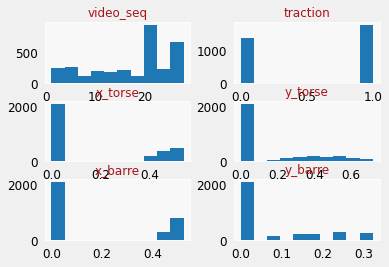

In [15]:
df = pd.read_csv("data/all_labels.csv", low_memory=False)

plt.figure(figsize= (16,16))
df.hist()
plt.show()

In [16]:
df = pd.read_csv("data/all_labels.csv", low_memory=False)
df = df.loc[df.folder=="images2"]
df.reset_index(inplace=True)
df.head()

index    name   folder  video_seq  traction   x_torse   y_torse   x_barre  \
0   1519  im_348  images2         10         1  0.518203  0.212408  0.508914   
1   1523  im_365  images2         10         1  0.498062  0.453488  0.511628   
2   1528  im_420  images2         10         1  0.498024  0.489824  0.505269   
3   1530  im_495  images2         12         1  0.506744  0.525866  0.515013   
4   1534  im_260  images2         10         1  0.490310  0.505814  0.503876   

    y_barre    phase  
0  0.172975  testing  
1  0.160853  testing  
2  0.162199  testing  
3  0.164719  testing  
4  0.164729  testing

In [17]:
for name, param in model.named_modules():
    print(name, param)

 Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [51]:
from torchcam.cams import SmoothGradCAMpp, CAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
cam_extractor = CAM(model, '0.7', '1.head_class.0')

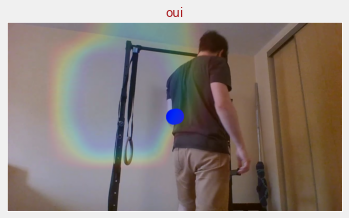

tensor([0.5050, 0.4996, 0.4981, 0.5020], device='cuda:0')
tensor([[0.1933]], device='cuda:0')


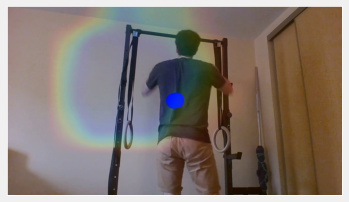

tensor([0.5052, 0.4997, 0.4980, 0.5018], device='cuda:0')
tensor([[0.1796]], device='cuda:0')


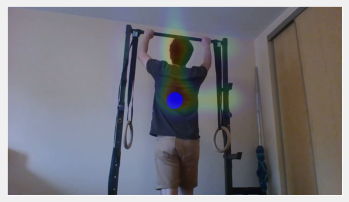

tensor([0.5023, 0.4985, 0.4993, 0.5031], device='cuda:0')
tensor([[0.7399]], device='cuda:0')


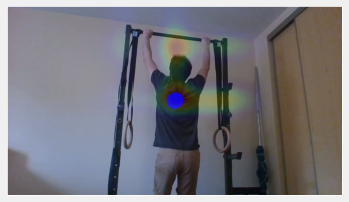

tensor([0.5029, 0.4987, 0.4999, 0.5035], device='cuda:0')
tensor([[0.6409]], device='cuda:0')


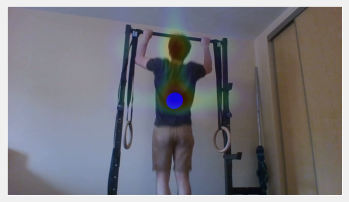

tensor([0.5022, 0.4987, 0.4989, 0.5029], device='cuda:0')
tensor([[0.7844]], device='cuda:0')


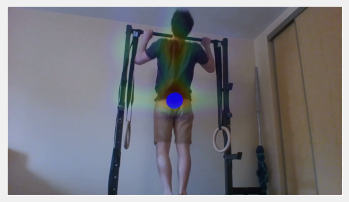

tensor([0.5021, 0.4987, 0.4987, 0.5027], device='cuda:0')
tensor([[0.8134]], device='cuda:0')


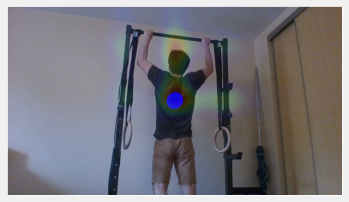

tensor([0.5024, 0.4985, 0.4995, 0.5032], device='cuda:0')
tensor([[0.7240]], device='cuda:0')


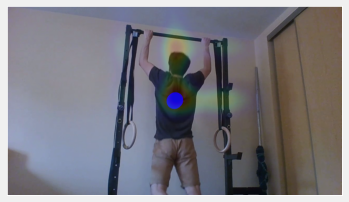

tensor([0.5025, 0.4986, 0.4998, 0.5034], device='cuda:0')
tensor([[0.6804]], device='cuda:0')


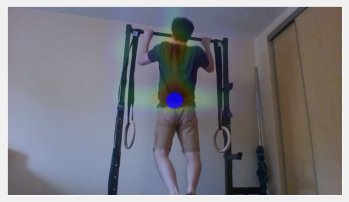

tensor([0.5020, 0.4987, 0.4985, 0.5026], device='cuda:0')
tensor([[0.8368]], device='cuda:0')


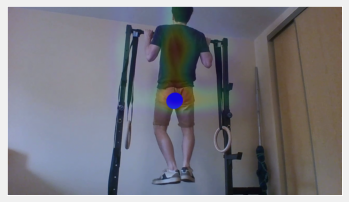

tensor([0.5022, 0.4987, 0.4988, 0.5028], device='cuda:0')
tensor([[0.8000]], device='cuda:0')


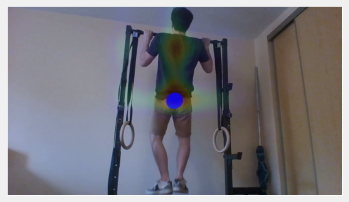

tensor([0.5023, 0.4987, 0.4991, 0.5030], device='cuda:0')
tensor([[0.7686]], device='cuda:0')


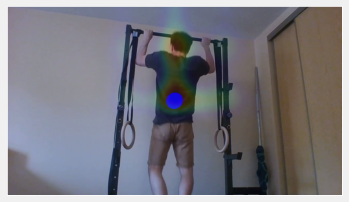

tensor([0.5022, 0.4987, 0.4989, 0.5029], device='cuda:0')
tensor([[0.7866]], device='cuda:0')


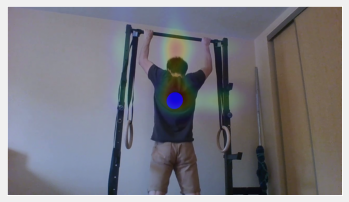

tensor([0.5023, 0.4986, 0.4994, 0.5032], device='cuda:0')
tensor([[0.7305]], device='cuda:0')


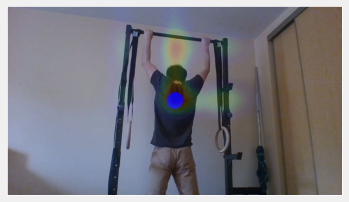

tensor([0.5023, 0.4985, 0.4994, 0.5032], device='cuda:0')
tensor([[0.7337]], device='cuda:0')


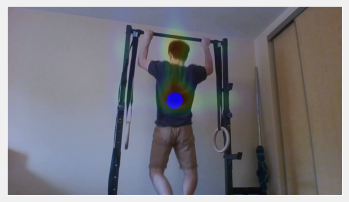

tensor([0.5022, 0.4987, 0.4990, 0.5029], device='cuda:0')
tensor([[0.7787]], device='cuda:0')


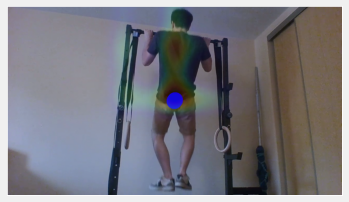

tensor([0.5023, 0.4985, 0.4994, 0.5031], device='cuda:0')
tensor([[0.7404]], device='cuda:0')


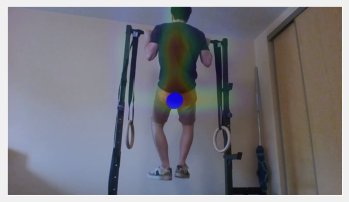

tensor([0.5022, 0.4987, 0.4988, 0.5028], device='cuda:0')
tensor([[0.7982]], device='cuda:0')


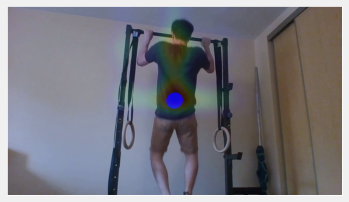

tensor([0.5021, 0.4987, 0.4985, 0.5026], device='cuda:0')
tensor([[0.8353]], device='cuda:0')


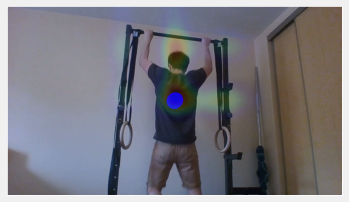

tensor([0.5024, 0.4986, 0.4995, 0.5032], device='cuda:0')
tensor([[0.7277]], device='cuda:0')


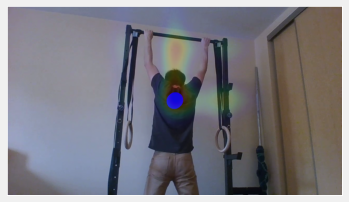

tensor([0.5025, 0.4986, 0.4995, 0.5031], device='cuda:0')
tensor([[0.7283]], device='cuda:0')


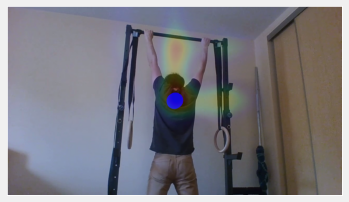

tensor([0.5027, 0.4987, 0.4997, 0.5032], device='cuda:0')
tensor([[0.6968]], device='cuda:0')


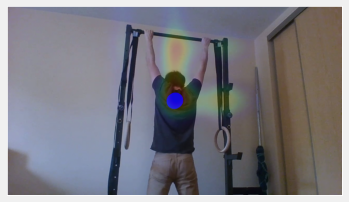

tensor([0.5026, 0.4987, 0.4996, 0.5032], device='cuda:0')
tensor([[0.7089]], device='cuda:0')


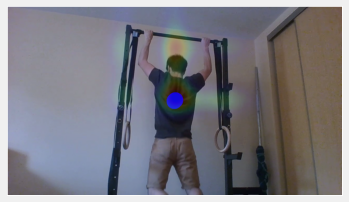

tensor([0.5024, 0.4985, 0.4996, 0.5033], device='cuda:0')
tensor([[0.7121]], device='cuda:0')


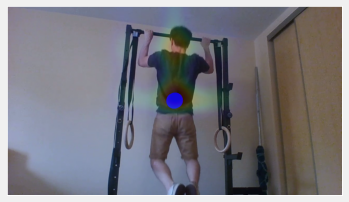

tensor([0.5021, 0.4987, 0.4986, 0.5026], device='cuda:0')
tensor([[0.8286]], device='cuda:0')


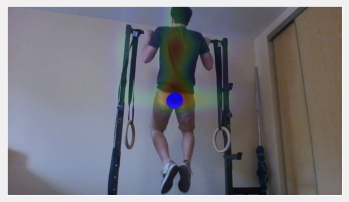

tensor([0.5022, 0.4987, 0.4989, 0.5028], device='cuda:0')
tensor([[0.7927]], device='cuda:0')


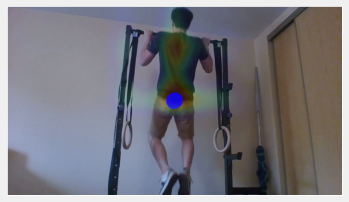

tensor([0.5023, 0.4986, 0.4992, 0.5030], device='cuda:0')
tensor([[0.7602]], device='cuda:0')


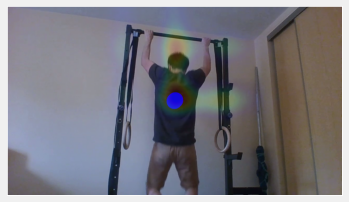

tensor([0.5026, 0.4986, 0.4996, 0.5032], device='cuda:0')
tensor([[0.7077]], device='cuda:0')


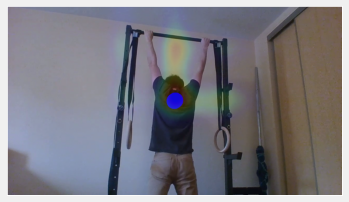

tensor([0.5024, 0.4986, 0.4993, 0.5031], device='cuda:0')
tensor([[0.7383]], device='cuda:0')


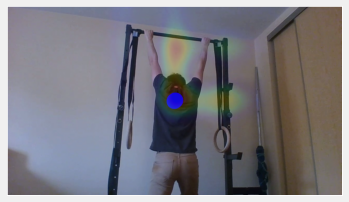

tensor([0.5028, 0.4986, 0.4999, 0.5035], device='cuda:0')
tensor([[0.6543]], device='cuda:0')


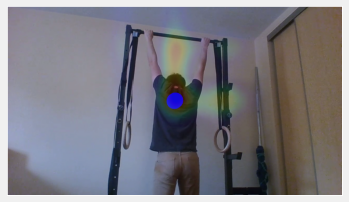

tensor([0.5027, 0.4987, 0.4997, 0.5033], device='cuda:0')
tensor([[0.6921]], device='cuda:0')


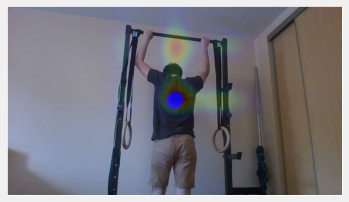

tensor([0.5024, 0.4985, 0.4997, 0.5034], device='cuda:0')
tensor([[0.6967]], device='cuda:0')


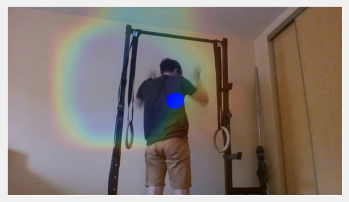

tensor([0.5048, 0.4995, 0.4981, 0.5020], device='cuda:0')
tensor([[0.1962]], device='cuda:0')


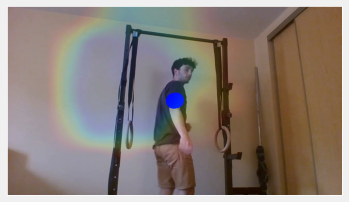

tensor([0.5053, 0.4998, 0.4978, 0.5016], device='cuda:0')
tensor([[0.1715]], device='cuda:0')


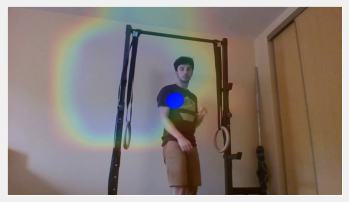

tensor([0.5052, 0.4998, 0.4979, 0.5017], device='cuda:0')
tensor([[0.1745]], device='cuda:0')


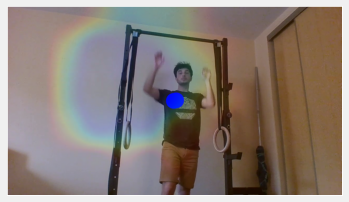

tensor([0.5052, 0.4998, 0.4979, 0.5017], device='cuda:0')
tensor([[0.1750]], device='cuda:0')


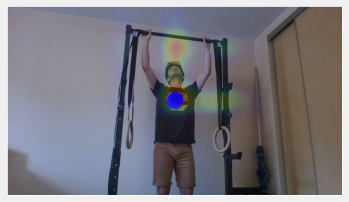

tensor([0.5025, 0.4985, 0.4998, 0.5034], device='cuda:0')
tensor([[0.6733]], device='cuda:0')


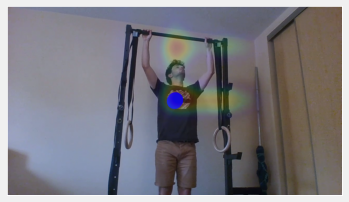

tensor([0.5027, 0.4985, 0.5000, 0.5036], device='cuda:0')
tensor([[0.5869]], device='cuda:0')


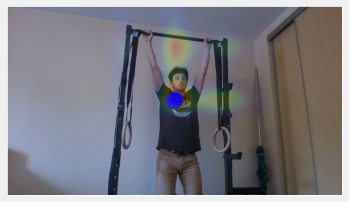

tensor([0.5025, 0.4986, 0.4995, 0.5031], device='cuda:0')
tensor([[0.7271]], device='cuda:0')


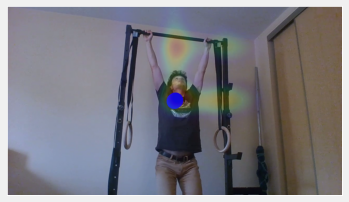

tensor([0.5031, 0.4988, 0.4999, 0.5034], device='cuda:0')
tensor([[0.6562]], device='cuda:0')


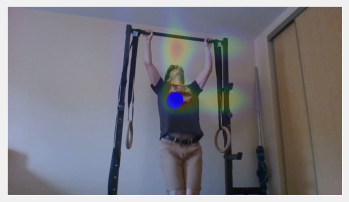

tensor([0.5026, 0.4986, 0.4997, 0.5033], device='cuda:0')
tensor([[0.6978]], device='cuda:0')


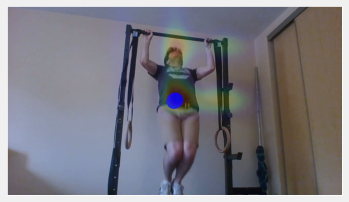

tensor([0.5028, 0.4986, 0.4999, 0.5033], device='cuda:0')
tensor([[0.6737]], device='cuda:0')


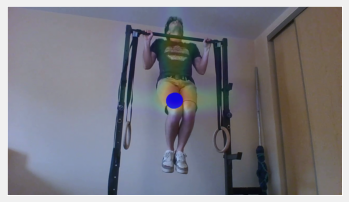

tensor([0.5020, 0.4987, 0.4983, 0.5025], device='cuda:0')
tensor([[0.8521]], device='cuda:0')


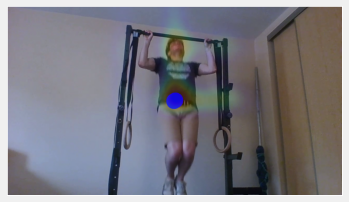

tensor([0.5023, 0.4986, 0.4991, 0.5029], device='cuda:0')
tensor([[0.7710]], device='cuda:0')


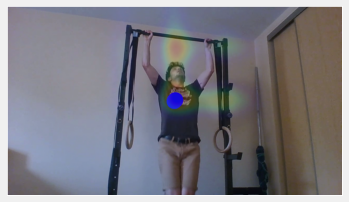

tensor([0.5025, 0.4985, 0.4997, 0.5033], device='cuda:0')
tensor([[0.7055]], device='cuda:0')


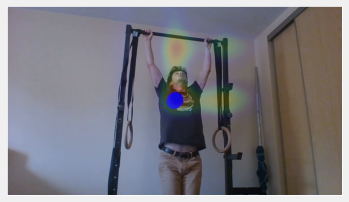

tensor([0.5027, 0.4986, 0.4997, 0.5032], device='cuda:0')
tensor([[0.7034]], device='cuda:0')


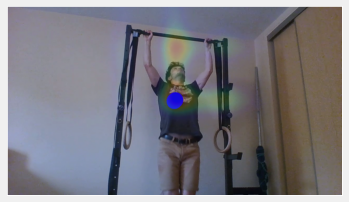

tensor([0.5024, 0.4985, 0.4994, 0.5030], device='cuda:0')
tensor([[0.7444]], device='cuda:0')


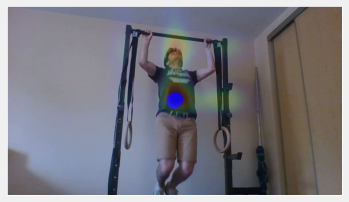

tensor([0.5025, 0.4986, 0.4996, 0.5032], device='cuda:0')
tensor([[0.7147]], device='cuda:0')


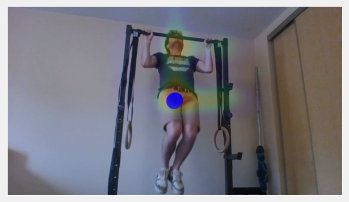

tensor([0.5023, 0.4987, 0.4990, 0.5028], device='cuda:0')
tensor([[0.7889]], device='cuda:0')


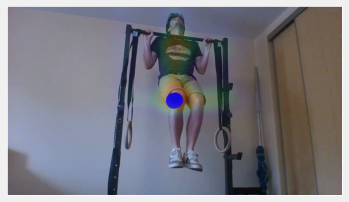

tensor([0.5020, 0.4987, 0.4983, 0.5025], device='cuda:0')
tensor([[0.8520]], device='cuda:0')


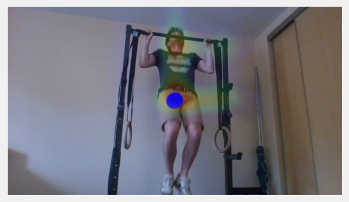

tensor([0.5023, 0.4988, 0.4989, 0.5027], device='cuda:0')
tensor([[0.8062]], device='cuda:0')


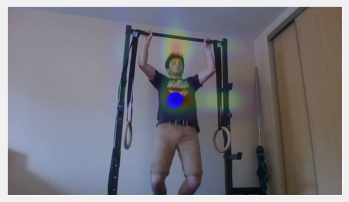

tensor([0.5026, 0.4985, 0.4997, 0.5033], device='cuda:0')
tensor([[0.6931]], device='cuda:0')


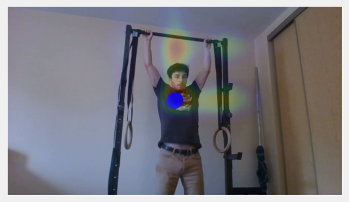

tensor([0.5029, 0.4987, 0.4998, 0.5032], device='cuda:0')
tensor([[0.6856]], device='cuda:0')


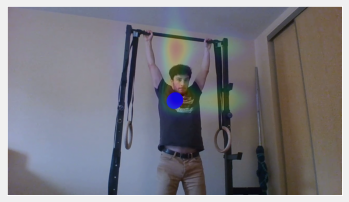

tensor([0.5026, 0.4986, 0.4996, 0.5031], device='cuda:0')
tensor([[0.7164]], device='cuda:0')


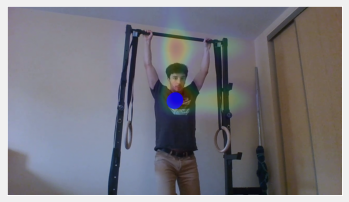

tensor([0.5027, 0.4986, 0.4997, 0.5032], device='cuda:0')
tensor([[0.7043]], device='cuda:0')


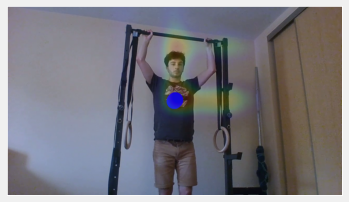

tensor([0.5030, 0.4986, 0.5000, 0.5036], device='cuda:0')
tensor([[0.6066]], device='cuda:0')


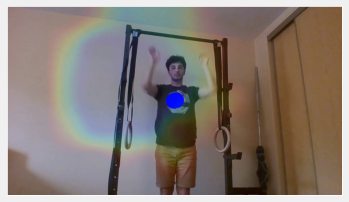

tensor([0.5050, 0.4997, 0.4980, 0.5018], device='cuda:0')
tensor([[0.1822]], device='cuda:0')


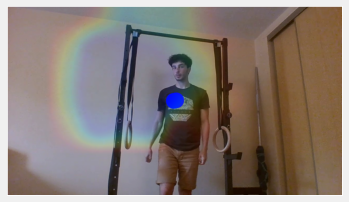

tensor([0.5051, 0.4997, 0.4979, 0.5018], device='cuda:0')
tensor([[0.1807]], device='cuda:0')


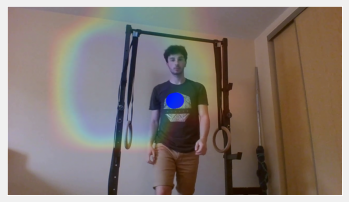

tensor([0.5050, 0.4997, 0.4980, 0.5018], device='cuda:0')
tensor([[0.1838]], device='cuda:0')


In [53]:
model.eval()

iou_threshold = 0.3
    
fig,ax = plt.subplots()
plt.title("oui")
plt.yticks([])
plt.xticks([])
yl = []
for i in range(1,802,14):
    image_path = 'data/images/images2/im_' + str(i) + '.jpg'        
    image = Image.open(image_path)
    image2 = vanilla_transform(image).to(device).unsqueeze(0)
    image = np.asarray(image)
    #y0 = df.iloc[i,3:7]
    with torch.no_grad(): pred = model(image2)
    activation_map = cam_extractor(torch.sigmoid(pred[1].squeeze(0)).argmax().item(), torch.sigmoid(pred[1]))
    y = pred[0].squeeze().detach().to('cpu').numpy()  
     
    #activation_map = cam_extractor(0, pred[0][0])
    image_width = image.shape[1]#/224
    image_height = image.shape[0]#/224
    yl.append([i, y[1]])
   
    img_to_draw = cv2.circle(image,  (int(y[0] * image_width) , int(y[1] * image_height)), 30, (10,0,250), -1)
    img_to_draw = cv2.circle(img_to_draw,  (int(y[2] * image_width), int(y[3] * image_height)), 30, (0,10,250), -1)
    #img_to_draw = cv2.circle(img_to_draw,  (int(y0.x_torse * image_width) , int(y0.y_torse * image_height)), 10, (100,255,0), -1)
    #img_to_draw = cv2.circle(img_to_draw,  (int(true_bboxe[2] * image_width), int(true_bboxe[3] * image_height)), 5, (0,255,0), -1)
    plt.xticks([])
    plt.yticks([])
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img_to_draw), to_pil_image(activation_map, mode='F'), alpha=0.87)
    # Display it
    plt.imshow(result)
    plt.pause(0.000001)
    print(pred[0][0]) 
    print(torch.sigmoid(pred[1]))

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

y_brut = [1 - y[1] for y in yl]
ysmoothed = gaussian_filter1d(y_brut, sigma=2)

plt.figure(figsize= (48,8))
plt.plot([y[0] for y in yl] ,y_brut)
plt.plot([x+14 for x in df.index] ,[1 - y for y in df.y_torse])

In [ ]:
image_path = 'exemples/th.jpg'        
image = Image.open(image_path)
image2 = vanilla_transform(image).to(device).unsqueeze(0)
image = np.asarray(image)
#y0 = df.iloc[i,3:7]
with torch.no_grad(): pred = model(image2)
activation_map = cam_extractor(pred[1].squeeze(0).argmax().item(), torch.sigmoid(pred[1]))
y = pred[0].squeeze().detach().to('cpu').numpy()  

#activation_map = cam_extractor(0, pred[0][0])
image_width = image.shape[1]#/224
image_height = image.shape[0]#/224
yl.append([i, y[1]])

img_to_draw = cv2.circle(image,  (int(y[0] * image_width) , int(y[1] * image_height)), 10, (100,150,255), -1)
img_to_draw = cv2.circle(img_to_draw,  (int(y[2] * image_width), int(y[3] * image_height)), 10, (0,150,255), -1)
#img_to_draw = cv2.circle(img_to_draw,  (int(y0.x_torse * image_width) , int(y0.y_torse * image_height)), 10, (100,255,0), -1)
#img_to_draw = cv2.circle(img_to_draw,  (int(true_bboxe[2] * image_width), int(true_bboxe[3] * image_height)), 5, (0,255,0), -1)
plt.xticks([])
plt.yticks([])
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img_to_draw), to_pil_image(activation_map, mode='F'), alpha=0.7)
# Display it
plt.imshow(result)
plt.pause(0.000001)
print(pred[0][0]) 
print(torch.sigmoid(pred[1]))

In [ ]:
!unzip exemples.zip -d .

In [ ]:
!rm -r exemples/